In [1]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.base import clone

from sklearn.pipeline import Pipeline

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#Set a random state
rs = 4

#Set our CVs
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)
cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=rs)

#Set the scaler
scaler = PowerTransformer()

In [2]:
#Get current directory 
path = os.getcwd() 

#Get parent directory 
parent = os.path.dirname(path)

#Move to the directory with data
train_csv = os.path.join(parent, "data", "train.csv")

#Import our dataset
dataset = pd.read_csv(train_csv, delimiter = '|')

#Clean the dataset (drop unrealistic entries)
dataset_org = dataset.copy()
dataset = dataset[dataset['scannedLineItemsPerSecond'] < 4]
cutted = len(dataset_org)-len(dataset)
print(f"{cutted} entries removed due to errors in feature 'scannedLineItemsPerSecond'.")

#Add new feature 'totalItems'
dataset = dataset.assign(totalItems = dataset.totalScanTimeInSeconds * dataset.scannedLineItemsPerSecond)

#Add new feature 'suspicious' as frauds only occur at trustLevels 1-2, all others are non-fraudulent
suspicious = dataset['trustLevel'].copy()
suspicious[suspicious > 2] = 3
dataset = dataset.assign(suspicious = suspicious)

#Drop 'trustLevel' as it is too similar to 'suspicious'
dataset = dataset.drop("trustLevel", axis=1)

#Add new feature 'avgLineItemValue'
dataset = dataset.assign(avgLineItemValue = dataset.valuePerSecond / dataset.scannedLineItemsPerSecond)

4 entries removed due to errors in feature 'scannedLineItemsPerSecond'.


In [3]:
#Split the dataset in X and y
X = dataset.drop('fraud', axis=1)
y = dataset.fraud

In [4]:
X.head()

,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalItems,suspicious,avgLineItemValue
0,1054,54.70,7,0,3,0.027514,0.051898,0.241379,29.0,3,1.886207
1,108,27.36,5,2,4,0.129630,0.253333,0.357143,14.0,3,1.954286
2,1516,62.16,3,10,5,0.008575,0.041003,0.230769,13.0,3,4.781538
3,1791,92.31,8,4,4,0.016192,0.051541,0.275862,29.0,3,3.183103
4,430,81.53,3,7,2,0.062791,0.189605,0.111111,27.0,3,3.019630


In [5]:
#Define monetary_score as our used metric
def monetary_score_func(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    monetary_value = (cm[0,0] * 0) + (cm[1, 0] * -5) + (cm[0, 1] * -25) + (cm[1, 1] * 5)
    max_monetary_value = (cm[1,0] + cm[1,1]) * 5
    return (monetary_value / max_monetary_value)

monetary_score = make_scorer(monetary_score_func)

In [6]:
#Define model and parameters
model = BaggingClassifier(base_estimator=AdaBoostClassifier(), random_state=rs, n_jobs=-1)
params = {"model__bootstrap": [True, False], #Are samples drawn with or without replacement? False = without replacement (Pasting), True = with replacement (Bagging)
          "model__max_samples": [0.25, 0.5, 0.75, 1.0], #Used number of samples to train the base estimators
          "model__n_estimators": [5, 10, 25, 50] #Number of base estimators
         }

#Create the model pipeline
try:
    pipe_model = Pipeline([
        ('sampler', sampler),
        ("scaler", scaler),
        ("model", model)
    ])
    
except NameError:
    pipe_model = Pipeline([    
        ("scaler", scaler),
        ("model", model)
    ])

#Define the grid search (inner cv)
grid = GridSearchCV(estimator=pipe_model, param_grid=params, scoring=monetary_score, cv=cv_inner, n_jobs=-1)
print(pipe_model)

Pipeline(steps=[('scaler', PowerTransformer()),
                ('model',
                 BaggingClassifier(base_estimator=AdaBoostClassifier(),
                                   n_jobs=-1, random_state=4))])


In [7]:
#Get the mean nested score to have an estimate on the expected performance
nested_cv = cross_validate(estimator=grid, X=X, y=y, cv=cv_outer, scoring=monetary_score, n_jobs=-1)
nested_score = nested_cv["test_score"].mean()

print(f"Scores of nested folds:\t\t{nested_cv['test_score']}")
print(f"Mean score of nested folds:\t{nested_score}")

Scores of nested folds:		[0.55       0.14285714 0.38095238 0.57142857 0.66666667]
Mean score of nested folds:	0.46238095238095234


In [8]:
#Fit the data to the GridSearch
grid.fit(X, y)

#Get the GridSearch results
results = pd.DataFrame(grid.cv_results_)

#Sort the output by mean_test_score
results.sort_values(by='mean_test_score', inplace=True, ignore_index=True, ascending=False)

#Drop everything but the param columns
results_grid = results.drop(["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time", "split0_test_score", "split1_test_score", "split2_test_score", "rank_test_score", "mean_test_score", "std_test_score"], axis=1)

#Get back mean_test_score and std_test_score (as double_std_test_score) to insert them in the first two columns
results_grid.insert(0, "mean_test_score", results["mean_test_score"])
results_grid.insert(1, "double_std_test_score", results["std_test_score"] * 2)

In [9]:
#See the top results (sorted by 'mean_test_score')
results_grid

,mean_test_score,double_std_test_score,param_model__bootstrap,param_model__max_samples,param_model__n_estimators,params
0,0.459944,0.252397,False,1,50,"{'model__bootstrap': False, 'model__max_sample..."
1,0.459944,0.252397,False,1,5,"{'model__bootstrap': False, 'model__max_sample..."
2,0.459944,0.252397,False,1,10,"{'model__bootstrap': False, 'model__max_sample..."
3,0.459944,0.252397,False,1,25,"{'model__bootstrap': False, 'model__max_sample..."
4,0.405042,0.224783,True,0.5,25,"{'model__bootstrap': True, 'model__max_samples..."
5,0.402801,0.207885,True,0.75,25,"{'model__bootstrap': True, 'model__max_samples..."
6,0.386835,0.478537,False,0.75,50,"{'model__bootstrap': False, 'model__max_sample..."
7,0.384874,0.100766,True,1,25,"{'model__bootstrap': True, 'model__max_samples..."
8,0.376751,0.293075,True,1,50,"{'model__bootstrap': True, 'model__max_samples..."
9,0.375630,0.294890,True,0.5,10,"{'model__bootstrap': True, 'model__max_samples..."


In [10]:
#Use best model as final_clf
final_pipe = clone(pipe_model)
final_pipe = final_pipe.set_params(**results_grid.loc[7, "params"])
print(final_pipe)

#How does the model perform?
cv_results = cross_validate(final_pipe, X, y, cv=cv_inner, scoring=monetary_score, n_jobs=-1)
print("\n\nPerformance on folds:\t\t",cv_results['test_score'])
print("Mean monetary score:\t\t", cv_results['test_score'].mean())
print("Double Standard Deviation:\t", 2*cv_results['test_score'].std())

Pipeline(steps=[('scaler', PowerTransformer()),
                ('model',
                 BaggingClassifier(base_estimator=AdaBoostClassifier(),
                                   n_estimators=25, n_jobs=-1,
                                   random_state=4))])


Performance on folds:		 [0.41176471 0.42857143 0.31428571]
Mean monetary score:		 0.3848739495798319
Double Standard Deviation:	 0.10076561190326998


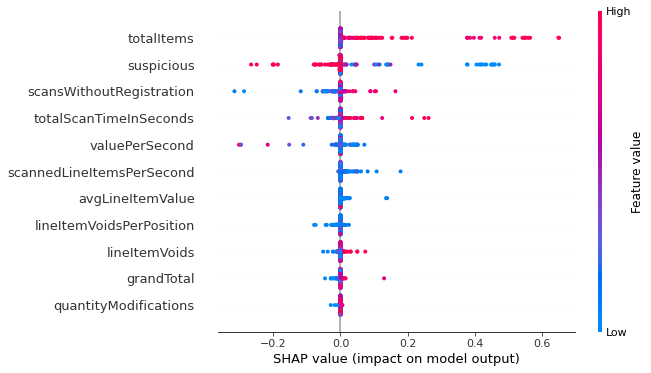

In [11]:
import shap
shap.initjs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs, stratify=y) 
final_pipe.fit(X_train, y_train)
X_train = shap.kmeans(X_train, 20)
explainer = shap.KernelExplainer(final_pipe.predict, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

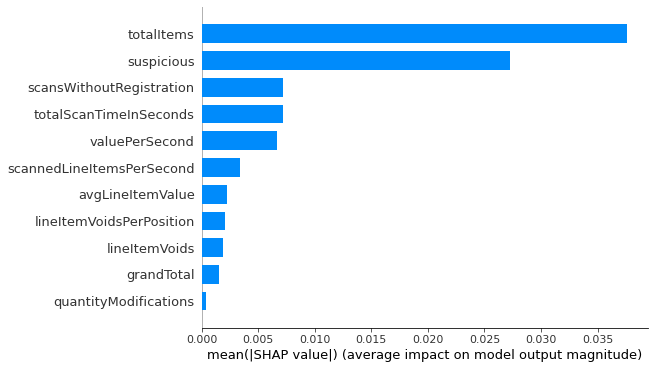

In [12]:
#Simple feature importance
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns, plot_type="bar")